# Strategy Details

### Code Author: Karl Ngan

Reference: Mathematical modeling and dynamic trading strategies for gold and bitcoin 


Link to reference: https://www.linkedin.com/posts/namnguyento_quantitativefinance-bitcoin-portfoliomanagement-activity-7173676442709377024-dIlp?utm_source=share&utm_medium=member_desktop

The main idea: Using the Holt-Winters model and the financial indicators to develop trading strategies on BTC and Gold market

### The part that is not same as the paper
- I am using the ETF price extracted from yfinance

In [270]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import pandas_ta as ta

start_date = '2016-01-01'
end_date = '2024-10-31'

In [271]:
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start= start_date, end= end_date)

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

In [272]:
#Downloading the data from Yahoo Finance
gold = load_data('GC=F')[['Open' , 'Close']]
btc = load_data('BTC-USD')[['Open' , 'Close']]
lookback = 30
#changing the dates format
gold['date'] = gold.index
btc['date'] = btc.index
gold['date'] = pd.to_datetime(gold['date'], format='%Y-%m-%d').dt.date
btc['date'] = pd.to_datetime(btc['date'], format='%Y-%m-%d').dt.date
gold.set_index('date', inplace=True)
btc.set_index('date', inplace=True)


In [273]:
#daily returns
gold['daily_return'] = gold['Close'].pct_change()
btc['daily_return'] = btc['Close'].pct_change()



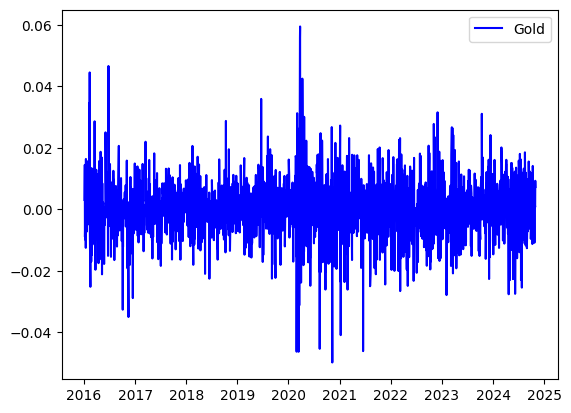

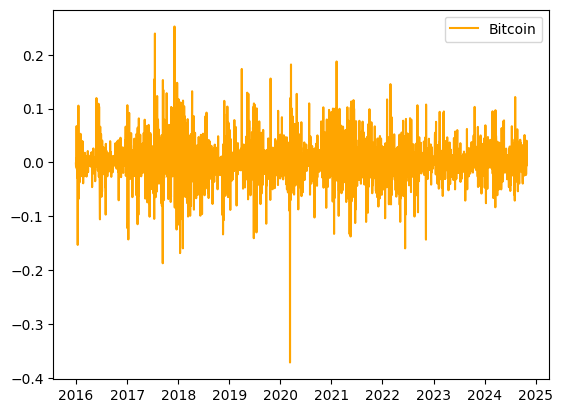

In [274]:
#plot the returns to see the data trend

plt.plot(gold['daily_return'], label='Gold', color='blue')
plt.legend()
plt.show()

plt.plot(btc['daily_return'], label='Bitcoin', color='orange')
plt.legend()
plt.show()

### Holt-Winters non-seasonal model


In [275]:
#define function for forecasting the price
def forecast_price(price):
    
    for i in range(len(price)):
        if i < lookback:
            continue

        #for the day i, we calculate the forecast value for the next day with pass 30 days data
        past_30_price = price['Close'].iloc[i-lookback:i]
        model = sm.tsa.ExponentialSmoothing(past_30_price, trend=None, damped_trend=False,initialization_method = "Heuristic").fit()
        
        #forecast the next day return
        price['forecast'].iloc[i] = model.forecast(steps=1)
        
    return price


In [276]:
#forecast the price for gold and bitcoin
#ignore warning
import warnings
warnings.filterwarnings("ignore")

gold['forecast'] = np.nan
gold = forecast_price(gold)

btc['forecast'] = np.nan
btc = forecast_price(btc)

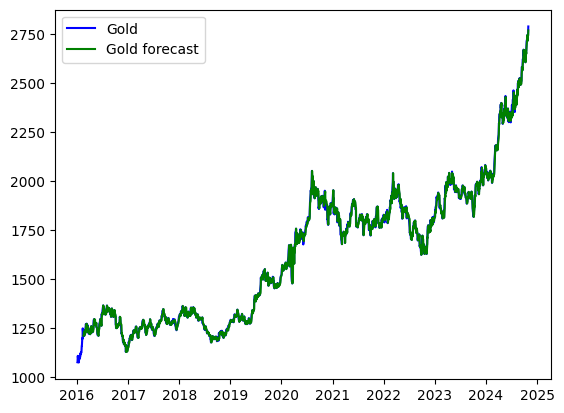

In [277]:
#plottting the forecasted price for 2021 only
plt.plot(gold['Close'], label='Gold', color='blue')
plt.plot(gold['forecast'], label='Gold forecast', color='green')
plt.legend()


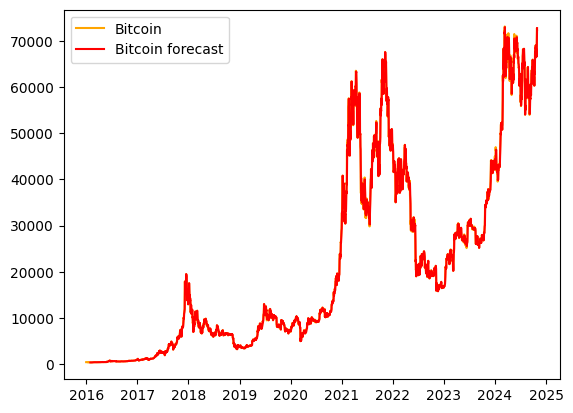

In [278]:
#plotting the forecasted price
plt.plot(btc['Close'], label='Bitcoin', color='orange')
plt.plot(btc['forecast'], label='Bitcoin forecast', color='red')
plt.legend()

In [279]:
#checking the accruacy of the forecast at least on the direction of the price
#create new dataframe to store the forecasted direction
gold_acc = gold.copy()
gold_acc['forecast_direction'] = np.nan
gold_acc['forecast_direction'].loc[gold['forecast'] > gold['Close']] = 1
gold_acc['forecast_direction'].loc[gold['forecast'] < gold['Close']] = -1

gold_acc['actual_direction'] = np.nan
gold_acc['actual_direction'].loc[gold['daily_return'] > 0] = 1
gold_acc['actual_direction'].loc[gold['daily_return'] < 0] = -1
gold_acc['actual_direction'] = gold_acc['actual_direction'].shift(-1)

gold_acc['correct'] = np.nan
gold_acc['correct'].loc[gold_acc['forecast_direction'] == gold_acc['actual_direction']] = 1
gold_acc['correct'].loc[gold_acc['forecast_direction'] != gold_acc['actual_direction']] = 0

gold_acc.dropna(inplace=True)

gold_acc['correct'].value_counts()





correct
1.0    1123
0.0    1056
Name: count, dtype: int64

In [280]:

btc_acc = btc.copy()
btc_acc['forecast_direction'] = np.nan
btc_acc['forecast_direction'].loc[btc['forecast'] > btc['Close']] = 1
btc_acc['forecast_direction'].loc[btc['forecast'] < btc['Close']] = -1

btc_acc['actual_direction'] = np.nan
btc_acc['actual_direction'].loc[btc['daily_return'] > 0] = 1
btc_acc['actual_direction'].loc[btc['daily_return'] < 0] = -1
btc_acc['actual_direction'] = btc_acc['actual_direction'].shift(-1)

btc_acc['correct'] = np.nan
btc_acc['correct'].loc[btc_acc['forecast_direction'] == btc_acc['actual_direction']] = 1
btc_acc['correct'].loc[btc_acc['forecast_direction'] != btc_acc['actual_direction']] = 0

#drop if forecast is nan
btc_acc.dropna(inplace=True)
btc_acc['correct'].value_counts()


correct
1.0    1655
0.0    1539
Name: count, dtype: int64

In [281]:
#calculate the accuracy
print("Gold forecast accuracy: ", gold_acc['correct'].sum() / len(gold_acc))
print("Bitcoin forecast accuracy: ", btc_acc['correct'].sum() / len(btc_acc))

Gold forecast accuracy:  0.5153740247820101
Bitcoin forecast accuracy:  0.5181590482154039


 the forecasted price has around 52% accuracy on both BTC and Gold prediction. We may further develop new strategies based on it. 

## Trading Strategy 1 Overview:

If the predicted price is larger than today's price, we long in the next day, otherwise we short. No holding

In [282]:

#Gold Strategy 1
Gold_Strategy1_returns_holder = []
flag = 0
for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    #if the forecasted price is higher than the current price, we buy
    if gold['forecast'].iloc[i] > gold['Close'].iloc[i]:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        #using ith price to predict and make decision on i+1th price
        Gold_Strategy1_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)
    else:
        if  flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy1_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)


Gold_Strategy1_Returns_df = pd.DataFrame(Gold_Strategy1_returns_holder)
Gold_Strategy1_Returns_df.columns = ['Gold_Strategy1_Returns']
Gold_Strategy1_Returns_df.index = gold.index[lookback+1:]


#BTC Strategy 1
BTC_Strategy1_returns_holder = []
flag = 0 
for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    #if the forecasted price is higher than the current price, we buy
    if btc['forecast'].iloc[i] > btc['Close'].iloc[i]:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        
        BTC_Strategy1_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)
            
    else:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy1_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)

BTC_Strategy_Returns_df = pd.DataFrame(BTC_Strategy1_returns_holder)
BTC_Strategy_Returns_df.columns = ['BTC_Strategy1_Returns']
BTC_Strategy_Returns_df.index = btc.index[lookback+1:]


#Results    

results = pd.DataFrame(columns=['Mean', 'SD', 'Sharpe'])
results.loc['Gold_Strategy1'] = [Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].mean(), Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].std(), Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].mean()/Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].std()]
results.loc['BTC_Strategy1'] = [BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].mean(), BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].std(), BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].mean()/BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].std()]

print(results)

                    Mean        SD    Sharpe
Gold_Strategy1 -0.001012  0.009177 -0.110238
BTC_Strategy1  -0.001726  0.036410 -0.047411


### Refining Strategy 1 

Oberving the results from Strategy 1, it is not profitable mainly due to the transaction cost and the errors on model.

Taking this into account, we are going to further refine the result with more conditioners.

In [283]:
#Not to trade if the price difference is smaller than the transaction cost
#Gold Strategy 1.5
Gold_Strategy1_5_returns_holder = []
flag = 0

for i in range(len(gold)-1):
    if i < lookback:
        continue

    #if the forecasted price is higher than the current price and the tx cost, we buy
    if gold['forecast'].iloc[i] > gold['Close'].iloc[i]* 1.0025:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        Gold_Strategy1_5_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)

    elif gold['forecast'].iloc[i] < gold['Close'].iloc[i]*1.0025:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0

        Gold_Strategy1_5_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)
    
    else:
        Gold_Strategy1_5_returns_holder.append(gold['daily_return'].iloc[i+1]*flag)

Gold_Strategy1_5_returns_df = pd.DataFrame(Gold_Strategy1_5_returns_holder)
Gold_Strategy1_5_returns_df.columns = ['Gold_Strategy1_5_Returns']
Gold_Strategy1_5_returns_df.index = gold.index[lookback+1:]


#BTC Strategy 1.5
BTC_Strategy1_5_returns_holder = []
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue

    #if the forecasted price is higher than the current price and the tx cost, we buy
    if btc['forecast'].iloc[i] > btc['Close'].iloc[i]*1.0025 :
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        BTC_Strategy1_5_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)

    elif btc['forecast'].iloc[i] < btc['Close'].iloc[i]*(0.9975):
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0

        BTC_Strategy1_5_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)
    
    else:
        BTC_Strategy1_5_returns_holder.append(btc['daily_return'].iloc[i+1]*flag)

BTC_Strategy1_5_returns_df = pd.DataFrame(BTC_Strategy1_5_returns_holder)
BTC_Strategy1_5_returns_df.columns = ['BTC_Strategy1_5_Returns']
BTC_Strategy1_5_returns_df.index = btc.index[lookback+1:]

#Results

results.loc['Gold_Strategy1_5'] = [Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].mean(), Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].std(), Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].mean()/Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].std()]
results.loc['BTC_Strategy1_5'] = [BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].mean(), BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].std(), BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].mean()/BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].std()]

print(results)

                      Mean        SD    Sharpe
Gold_Strategy1   -0.001012  0.009177 -0.110238
BTC_Strategy1    -0.001726  0.036410 -0.047411
Gold_Strategy1_5 -0.001109  0.009141 -0.121284
BTC_Strategy1_5  -0.002144  0.036408 -0.058881


### Comments on the strategy 1
The strategy are not profitable mainly due to model's errors triggering the excess frequent long-short and the transaction cost associated.
We may use the financial indicators to generate better signals 


## Trading Strategy 2 Overview:

Calculating the SMA for gold and BTC. if they cross, we change the position of signals.

In [284]:
#SMA
gold['SMA'] = gold['Close'].rolling(window=65).mean()
btc['SMA'] = btc['Close'].rolling(window=30).mean()



#Gold Strategy 2
Gold_Strategy2_returns_holder = []
flag = 0

for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    if gold['forecast'].iloc[i] > gold['SMA'].iloc[i]*1.0025:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        Gold_Strategy2_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)
    elif gold['forecast'].iloc[i] < gold['SMA'].iloc[i]*0.9975:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy2_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)
    else:
        Gold_Strategy2_returns_holder.append(gold['daily_return'].iloc[i+1]*flag)

Gold_Strategy2_Returns_df = pd.DataFrame(Gold_Strategy2_returns_holder)
Gold_Strategy2_Returns_df.columns = ['Gold_Strategy2_Returns']
Gold_Strategy2_Returns_df.index = gold.index[lookback+1:]

#BTC Strategy 2
BTC_Strategy2_returns_holder = []
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    if btc['forecast'].iloc[i] > btc['SMA'].iloc[i]*1.0025:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        BTC_Strategy2_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)
    elif btc['forecast'].iloc[i] < btc['SMA'].iloc[i]*0.9975:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy2_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)
    else:
        BTC_Strategy2_returns_holder.append(btc['daily_return'].iloc[i+1]*flag)

BTC_Strategy2_Returns_df = pd.DataFrame(BTC_Strategy2_returns_holder)
BTC_Strategy2_Returns_df.columns = ['BTC_Strategy2_Returns']
BTC_Strategy2_Returns_df.index = btc.index[lookback+1:]

#Results

results.loc['Gold_Strategy2'] = [Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].mean(), Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].std(), Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].mean()/Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].std()]
results.loc['BTC_Strategy2'] = [BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].mean(), BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].std(), BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].mean()/BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].std()]


print(results)


                      Mean        SD    Sharpe
Gold_Strategy1   -0.001012  0.009177 -0.110238
BTC_Strategy1    -0.001726  0.036410 -0.047411
Gold_Strategy1_5 -0.001109  0.009141 -0.121284
BTC_Strategy1_5  -0.002144  0.036408 -0.058881
Gold_Strategy2    0.000033  0.009029  0.003676
BTC_Strategy2     0.001517  0.036419  0.041659


### Comments on Strategy 2 
Using the finanical indicators Simple moving average, the results are better than the simple trading strategies above.

## Strategy 3 & 3.5
Using bollinger band to generate signals:







Strategy 3: considering the overbuying/overselling and the trend

If forecast price is larger than upperband, sell it

If forecast price is smaller than upperband but larger than middleband, buy it

If forecast price is smaller than middleband but larger than lowerband, sell it

If forecast price is smaller than lowerband, buy it



Strategy 3.5: considering the overbuying/overselling only

If forecast price is larger than upperband, sell it

If forecast price is smaller than lowerband, buy it

for the time within the band, we do not enter the market

In [285]:
#getting the Bollinger Bands
gold[['bb_lower','bb_middle','bb_upper']] = ta.bbands(gold['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]
btc[['bb_lower','bb_middle','bb_upper']] = ta.bbands(btc['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]

In [286]:
#Gold Strategy 3
Gold_Strategy3_returns_holder = []
tx_cost = 0.0025
flag = 0

for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    if gold['forecast'].iloc[i] > gold['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)

    elif (gold['forecast'].iloc[i] < gold['bb_upper'].iloc[i]) and (gold['forecast'].iloc[i] > gold['bb_middle'].iloc[i]):
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)

    elif (gold['forecast'].iloc[i] < gold['bb_middle'].iloc[i]) and (gold['forecast'].iloc[i] > gold['bb_lower'].iloc[i]):
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)

    else:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)


Gold_Strategy3_Returns_df = pd.DataFrame(Gold_Strategy3_returns_holder)
Gold_Strategy3_Returns_df.columns = ['Gold_Strategy3_Returns']
Gold_Strategy3_Returns_df.index = gold.index[lookback+1:]


#BTC Strategy 3
BTC_Strategy3_returns_holder = []
tx_cost = 0.0025
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    if btc['forecast'].iloc[i] > btc['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)

    elif (btc['forecast'].iloc[i] < btc['bb_upper'].iloc[i]) and (btc['forecast'].iloc[i] > btc['bb_middle'].iloc[i]):
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)

    elif (btc['forecast'].iloc[i] < btc['bb_middle'].iloc[i]) and (btc['forecast'].iloc[i] > btc['bb_lower'].iloc[i]):
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)

    else:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)

BTC_Strategy3_Returns_df = pd.DataFrame(BTC_Strategy3_returns_holder)
BTC_Strategy3_Returns_df.columns = ['BTC_Strategy3_Returns']
BTC_Strategy3_Returns_df.index = btc.index[lookback+1:]



#Results

results.loc['Gold_Strategy3'] = [Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].mean(), Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].std(), Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].mean()/Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].std()]
results.loc['BTC_Strategy3'] = [BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].mean(), BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].std(), BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].mean()/BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].std()]

print(results)
    

                      Mean        SD    Sharpe
Gold_Strategy1   -0.001012  0.009177 -0.110238
BTC_Strategy1    -0.001726  0.036410 -0.047411
Gold_Strategy1_5 -0.001109  0.009141 -0.121284
BTC_Strategy1_5  -0.002144  0.036408 -0.058881
Gold_Strategy2    0.000033  0.009029  0.003676
BTC_Strategy2     0.001517  0.036419  0.041659
Gold_Strategy3   -0.000550  0.009190 -0.059900
BTC_Strategy3     0.000525  0.036470  0.014390


In [287]:
#Gold Strategy 3.5
Gold_Strategy3_5_returns_holder = []
tx_cost = 0.0025
flag = 0

for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    if gold['forecast'].iloc[i] > gold['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy3_5_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)

    elif gold['forecast'].iloc[i] < gold['bb_lower'].iloc[i]:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        Gold_Strategy3_5_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)

    else:
        if flag != 0:
            tx_cost = 0.0025
            flag = 0
        else:
            tx_cost = 0
        Gold_Strategy3_5_returns_holder.append(0 - tx_cost)

Gold_Strategy3_5_Returns_df = pd.DataFrame(Gold_Strategy3_5_returns_holder)
Gold_Strategy3_5_Returns_df.columns = ['Gold_Strategy3_5_Returns']
Gold_Strategy3_5_Returns_df.index = gold.index[lookback+1:]

#BTC Strategy 3.5
BTC_Strategy3_5_returns_holder = []
tx_cost = 0.0025
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    if btc['forecast'].iloc[i] > btc['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy3_5_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)

    elif btc['forecast'].iloc[i] < btc['bb_lower'].iloc[i]:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        BTC_Strategy3_5_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)

    else:
        if flag != 0:
            tx_cost = 0.0025
            flag = 0
        else:
            tx_cost = 0
        BTC_Strategy3_5_returns_holder.append(0 - tx_cost)


BTC_Strategy3_5_Returns_df = pd.DataFrame(BTC_Strategy3_5_returns_holder)
BTC_Strategy3_5_Returns_df.columns = ['BTC_Strategy3_5_Returns']
BTC_Strategy3_5_Returns_df.index = btc.index[lookback+1:]

#Results

results.loc['Gold_Strategy3_5'] = [Gold_Strategy3_5_Returns_df['Gold_Strategy3_5_Returns'].mean(), Gold_Strategy3_5_Returns_df['Gold_Strategy3_5_Returns'].std(), Gold_Strategy3_5_Returns_df['Gold_Strategy3_5_Returns'].mean()/Gold_Strategy3_5_Returns_df['Gold_Strategy3_5_Returns'].std()]
results.loc['BTC_Strategy3_5'] = [BTC_Strategy3_5_Returns_df['BTC_Strategy3_5_Returns'].mean(), BTC_Strategy3_5_Returns_df['BTC_Strategy3_5_Returns'].std(), BTC_Strategy3_5_Returns_df['BTC_Strategy3_5_Returns'].mean()/BTC_Strategy3_5_Returns_df['BTC_Strategy3_5_Returns'].std()]

print(results)

                      Mean        SD    Sharpe
Gold_Strategy1   -0.001012  0.009177 -0.110238
BTC_Strategy1    -0.001726  0.036410 -0.047411
Gold_Strategy1_5 -0.001109  0.009141 -0.121284
BTC_Strategy1_5  -0.002144  0.036408 -0.058881
Gold_Strategy2    0.000033  0.009029  0.003676
BTC_Strategy2     0.001517  0.036419  0.041659
Gold_Strategy3   -0.000550  0.009190 -0.059900
BTC_Strategy3     0.000525  0.036470  0.014390
Gold_Strategy3_5 -0.000188  0.002539 -0.074115
BTC_Strategy3_5  -0.000597  0.011960 -0.049952


## Result Analysis


In [288]:
#saving all the returns in 1 dataframe
gold_all_returns = pd.concat([Gold_Strategy1_Returns_df, Gold_Strategy1_5_returns_df, Gold_Strategy2_Returns_df, Gold_Strategy3_Returns_df, Gold_Strategy3_5_Returns_df], axis=1)
btc_all_returns = pd.concat([BTC_Strategy_Returns_df, BTC_Strategy1_5_returns_df, BTC_Strategy2_Returns_df  , BTC_Strategy3_Returns_df, BTC_Strategy3_5_Returns_df], axis=1)

#create another dataframe for cumulative return cumprod
gold_cumulative_returns = (1 + gold_all_returns).cumprod()
btc_cumulative_returns = (1 + btc_all_returns).cumprod()



<Axes: xlabel='date'>

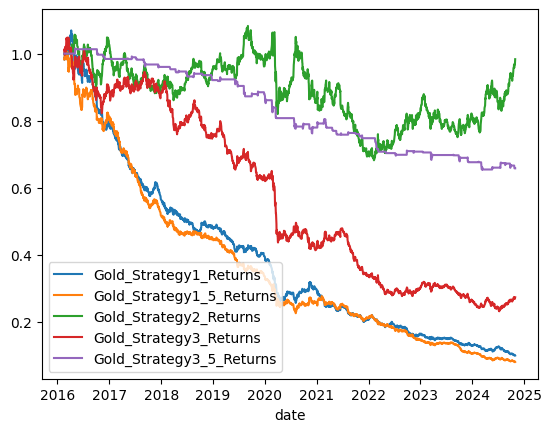

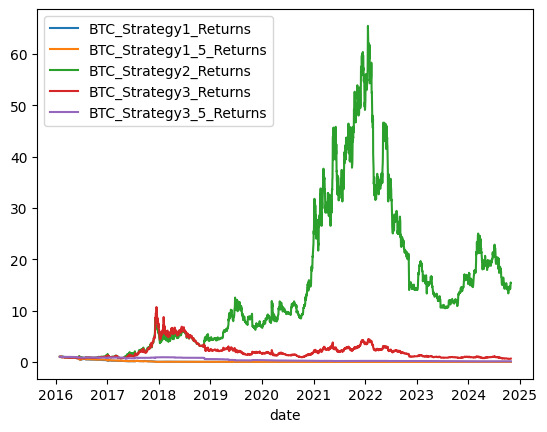

In [289]:
#plot the cumulative returns
gold_cumulative_returns.plot()
btc_cumulative_returns.plot()

In [290]:
#Sharpe
gold_sharpe = gold_all_returns.mean()*np.sqrt(252) / gold_all_returns.std()
btc_sharpe = btc_all_returns.mean() *np.sqrt(365) / btc_all_returns.std()

print(gold_sharpe)
print(btc_sharpe)

Gold_Strategy1_Returns     -1.749973
Gold_Strategy1_5_Returns   -1.925324
Gold_Strategy2_Returns      0.058362
Gold_Strategy3_Returns     -0.950877
Gold_Strategy3_5_Returns   -1.176540
dtype: float64
BTC_Strategy1_Returns     -0.905795
BTC_Strategy1_5_Returns   -1.124919
BTC_Strategy2_Returns      0.795888
BTC_Strategy3_Returns      0.274911
BTC_Strategy3_5_Returns   -0.954337
dtype: float64


The SMA stratgies appears to match with Holt winters model better, lets extend this strategy to other asset class

In [291]:
#Oil
oil = load_data('CL=F')[['Open' , 'Close']]
oil['daily_return'] = oil['Close'].pct_change()
oil['date'] = oil.index
oil['date'] = pd.to_datetime(oil['date'], format='%Y-%m-%d').dt.date

oil.set_index('date', inplace=True)

#forecast the price for oil
oil['forecast'] = np.nan
oil = forecast_price(oil)

#SMA strategy
oil['SMA'] = oil['Close'].rolling(window=65).mean()

Oil_returns_holder = []
flag = 0

for i in range(len(oil)-1):
    if i < lookback:
        continue
    
    if oil['forecast'].iloc[i] > oil['SMA'].iloc[i]*1.0025:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        Oil_returns_holder.append(oil['daily_return'].iloc[i+1] - tx_cost)
    elif oil['forecast'].iloc[i] < oil['SMA'].iloc[i]*0.9975:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Oil_returns_holder.append(-oil['daily_return'].iloc[i+1] - tx_cost)
    else:
        Oil_returns_holder.append(oil['daily_return'].iloc[i+1]*flag)

Oil_Returns_df = pd.DataFrame(Oil_returns_holder)
Oil_Returns_df.columns = ['Oil_Returns']
Oil_Returns_df.index = oil.index[lookback+1:]




In [292]:
#Results
print("Oil Strategy")
print("Mean: ", Oil_Returns_df['Oil_Returns'].mean()*np.sqrt(252))
print("SD: ", Oil_Returns_df['Oil_Returns'].std())
print("Sharpe: ", Oil_Returns_df['Oil_Returns'].mean()*np.sqrt(252)/Oil_Returns_df['Oil_Returns'].std())

Oil Strategy
Mean:  0.014143133224225075
SD:  0.07647270756451481
Sharpe:  0.18494353965816468


In [293]:
#ETH
eth = load_data('ETH-USD')[['Open' , 'Close']]
eth['daily_return'] = eth['Close'].pct_change()
eth['date'] = eth.index

eth['date'] = pd.to_datetime(eth['date'], format='%Y-%m-%d').dt.date

eth.set_index('date', inplace=True)

#forecast the price for eth
eth['forecast'] = np.nan
eth = forecast_price(eth)

#SMA strategy
eth['SMA'] = eth['Close'].rolling(window=30).mean()

ETH_returns_holder = []
flag = 0

for i in range(len(eth)-1):
    if i < lookback:
        continue
    
    if eth['forecast'].iloc[i] > eth['SMA'].iloc[i]*1.0025:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        ETH_returns_holder.append(eth['daily_return'].iloc[i+1] - tx_cost)
    elif eth['forecast'].iloc[i] < eth['SMA'].iloc[i]*0.9975:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        ETH_returns_holder.append(-eth['daily_return'].iloc[i+1] - tx_cost)
    else:
        ETH_returns_holder.append(eth['daily_return'].iloc[i+1]*flag)

ETH_Returns_df = pd.DataFrame(ETH_returns_holder)
ETH_Returns_df.columns = ['ETH_Returns']
ETH_Returns_df.index = eth.index[lookback+1:]





In [294]:
#Results
print("ETH Strategy")
print("Mean: ", ETH_Returns_df['ETH_Returns'].mean()*np.sqrt(365))
print("SD: ", ETH_Returns_df['ETH_Returns'].std())
print("Sharpe: ", ETH_Returns_df['ETH_Returns'].mean()*np.sqrt(365)/ETH_Returns_df['ETH_Returns'].std())

ETH Strategy
Mean:  0.0443057824689047
SD:  0.04581783716094512
Sharpe:  0.9669985580783965


### Final thought
SMA strategies shows the best results among others,
but the strategies appears to perform better in more volatile asset (crypto).

The accueacy of the Holt winters model largely affect the performance of the strategies, we may further finetune the models or using other prediction model to replace in order to improve result